(2, 64, 64, 64)


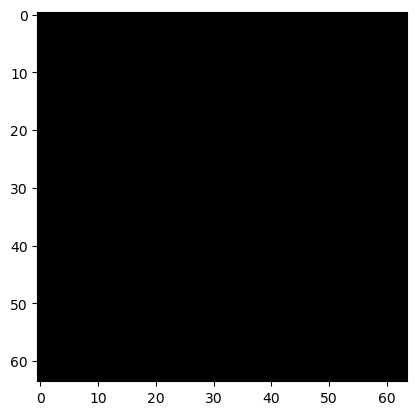

In [53]:
#@title 3D Phantom Definition

# Voxelised 3D medical imaging phantom (comprising of random shapes) in numpy ndarray format

import numpy as np

phan_size: int = 64
channels: int = 2 # Channel 0: Scattering Coefficient, Channel 1: Attenuation Coefficient
chan_scat_coef: int = 0
chan_atten_coef: int = 1

def create_random_voxel_phantom(shape=(channels, phan_size, phan_size, phan_size), num_shapes=3):
    """
    Creates a voxelized 3D medical imaging phantom with random shapes. (Values in range 0 to 1f)

    Args:
      shape: The shape of the 3D array (c, x, y, z).
      num_shapes: The number of random shapes to generate.

    Returns:
      A NumPy ndarray representing the 3D phantom.
    """

    phantom = np.zeros(shape, dtype=np.float32)

    for _ in range(num_shapes):
      # Randomly determine the shape of each object
      shape_type = np.random.choice(["sphere", "cube", "ellipsoid"])

      # Randomly select coordinates and dimensions for the shape
      center_x = np.random.randint(0, shape[-3])
      center_y = np.random.randint(0, shape[-2])
      center_z = np.random.randint(0, shape[-1])
      radius = np.random.randint(min(shape[-3:]) // 5, min(shape[-3:]) // 3) # Adjust radius based on phantom size

      # Generate voxel indices for the shape
      x_indices = np.arange(shape[-3])
      y_indices = np.arange(shape[-2])
      z_indices = np.arange(shape[-1])
      x, y, z = np.meshgrid(x_indices, y_indices, z_indices)

      if shape_type == "sphere":
        # Draw a sphere
        voxel_indices = (x - center_x)**2 + (y - center_y)**2 + (z - center_z)**2 <= radius**2
      elif shape_type == "cube":
        # Draw a cube
        voxel_indices = np.logical_and(np.abs(x - center_x) <= radius,
                                        np.logical_and(np.abs(y - center_y) <= radius,
                                                        np.abs(z - center_z) <= radius))

      elif shape_type == "ellipsoid":
          # Draw an ellipsoid with different radii along each axis
          a = radius  # x-axis radius
          b = radius * np.random.uniform(0.7, 1.3) # y-axis radius
          c = radius * np.random.uniform(0.7, 1.3) # z-axis radius
          voxel_indices = ((x - center_x)**2 / a**2) + ((y - center_y)**2 / b**2) + ((z - center_z)**2 / c**2) <= 1
      else:
        continue

      # Update the phantom
      phantom[chan_scat_coef][voxel_indices] = np.random.random()  # Assign random grayscale value
      phantom[chan_atten_coef][voxel_indices] = np.random.random()  # Assign random grayscale value for other channel

    return phantom

# Generate and display a phantom
phantom = create_random_voxel_phantom()
print(phantom.shape)
# You can now visualize or further process phantom
# Using matplotlib for visualization
import matplotlib.pyplot as plt
plt.imshow(phantom[chan_scat_coef,0,:,:], cmap="gray")
plt.show()



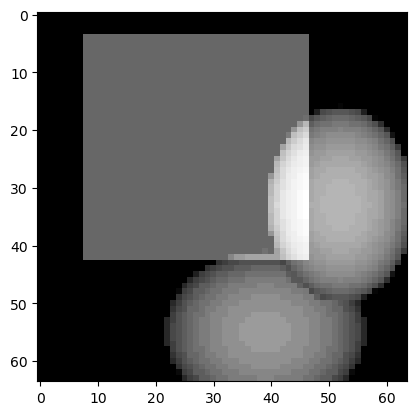

In [54]:
plt.imshow(np.sum(phantom, -3)[chan_scat_coef], cmap="gray")
plt.show()

In [71]:
#@title Siddon Path Tracing 3D

import math
import sys

def siddon_3d(p1: tuple, p2: tuple, phan_size: int) -> tuple[list, list]:
  # TODO: hmm, possible division by zero if one of our axes doesn't change from p1 to p2 (when calc. alpha)
  # ^^^ FIX: added epsilon
  # TODO: also... at the end, m doesn't cover all indices (as we'd go out of range otherwise)

  planes = phan_size + 1

  voxels_to_traverse: list[tuple] = []
  voxels_to_traverse_path_lens: list[float] = []

  # The corner of the pixel space where the axes intersect
  b_x = 0
  b_y = 0
  b_z = 0

  # Distance between planes
  d_x = 1
  d_y = 1
  d_z = 1

  def alpha_x(i: int) -> float:
    numerator = (b_x + i * d_x) - p1[0]
    denominator = p2[0] - p1[0] + sys.float_info.epsilon
    return numerator / denominator

  def alpha_y(j: int) -> float:
    numerator = (b_y + j * d_y) - p1[1]
    denominator = p2[1] - p1[1] + sys.float_info.epsilon
    return numerator / denominator

  def alpha_z(k: int) -> float:
    numerator = (b_z + k * d_z) - p1[2]
    denominator = p2[2] - p1[2] + sys.float_info.epsilon
    return numerator / denominator

  alpha_x_min = min(alpha_x(0), alpha_x(planes-1))
  alpha_x_max = max(alpha_x(0), alpha_x(planes-1))
  alpha_y_min = min(alpha_y(0), alpha_y(planes-1))
  alpha_y_max = max(alpha_y(0), alpha_y(planes-1))
  alpha_z_min = min(alpha_z(0), alpha_z(planes-1))
  alpha_z_max = max(alpha_z(0), alpha_z(planes-1))

  alpha_min = max(alpha_x_min, alpha_y_min, alpha_z_min)
  alpha_max = min(alpha_x_max, alpha_y_max, alpha_z_max)
  print(alpha_x_max, alpha_y_max, alpha_z_max)

  print(alpha_min, alpha_max)

  def p_x(alpha: float) -> float:
    return p1[0] + alpha * (p2[0] - p1[0])

  def p_y(alpha: float) -> float:
    return p1[1] + alpha * (p2[1] - p1[1])

  def p_z(alpha: float) -> float:
    return p1[2] + alpha * (p2[2] - p1[2])

  def phi_x(alpha: float) -> float:
    numerator = p_x(alpha) - b_x
    denominator = d_x
    return numerator / denominator

  def phi_y(alpha: float) -> float:
    numerator = p_y(alpha) - b_y
    denominator = d_y
    return numerator / denominator

  def phi_z(alpha: float) -> float:
    numerator = p_z(alpha) - b_z
    denominator = d_z
    return numerator / denominator

  # Determine i_min and i_max, j_min and j_max, k_min and k_max

  i_min: int | None = None
  i_max: int | None = None
  j_min: int | None = None
  j_max: int | None = None
  k_min: int | None = None
  k_max: int | None = None

  if p1[0] < p2[0]:
    i_min = 1 if alpha_min == alpha_x_min else math.ceil(phi_x(alpha_min))
    i_max = planes - 1 if alpha_max == alpha_x_max else math.floor(phi_x(alpha_max))
  else:
    i_max = planes - 2 if alpha_min == alpha_x_min else math.floor(phi_x(alpha_min))
    i_min = 0 if alpha_max == alpha_x_max else math.ceil(phi_x(alpha_max))

  if p1[1] < p2[1]:
    j_min = 1 if alpha_min == alpha_y_min else math.ceil(phi_y(alpha_min))
    j_max = planes - 1 if alpha_max == alpha_y_max else math.floor(phi_y(alpha_max))
  else:
    j_max = planes - 2 if alpha_min == alpha_y_min else math.floor(phi_y(alpha_min))
    j_min = 0 if alpha_max == alpha_y_max else math.ceil(phi_y(alpha_max))

  if p1[2] < p2[2]:
    k_min = 1 if alpha_min == alpha_z_min else math.ceil(phi_z(alpha_min))
    k_max = planes - 1 if alpha_max == alpha_z_max else math.floor(phi_z(alpha_max))
  else:
    k_max = planes - 2 if alpha_min == alpha_z_min else math.floor(phi_z(alpha_min))
    k_min = 0 if alpha_max == alpha_z_max else math.ceil(phi_z(alpha_max))

  # print(i_min, i_max, j_min, j_max, k_min, k_max)

  # Calc arrays alpha_x[] alpha_y[] alpha_z[] which hold parametric vals for intersection points of the
  # ray with the x- respect to y-planes, after the ray has entered pixel space.

  alpha_x_arr: list[float] = []
  alpha_y_arr: list[float] = []
  alpha_z_arr: list[float] = []

  # TODO: does the if/else really do anything?
  if p1[0] < p2[0]:
    alpha_x_arr = [alpha_x(i) for i in range(i_min, i_max+1, 1)]
  else:
    alpha_x_arr = [alpha_x(i) for i in range(i_max, i_min-1, -1)]

  if p1[1] < p2[1]:
    alpha_y_arr = [alpha_y(j) for j in range(j_min, j_max+1, 1)]
  else:
    alpha_y_arr = [alpha_y(j) for j in range(j_max, j_min-1, -1)]

  if p1[2] < p2[2]:
    alpha_z_arr = [alpha_z(k) for k in range(k_min, k_max+1, 1)]
  else:
    alpha_z_arr = [alpha_z(k) for k in range(k_max, k_min-1, -1)]

  # Combine alpha_min, alpha_ x,y,z _arr's together and sort acendingly
  alpha_xyz_arr: list[float] = [alpha_min] + alpha_x_arr + alpha_y_arr + alpha_z_arr + [alpha_max]
  # Remove duplicates
  alpha_xyz_arr = list(set(alpha_xyz_arr))
  alpha_xyz_arr.sort()

  # To calculate coordinates of intersected pixels
  def i(m: int) -> int:
    numerator = alpha_xyz_arr[m] + alpha_xyz_arr[m-1]
    denominator = 2
    return math.floor(phi_x(numerator / denominator))

  def j(m: int) -> int:
    numerator = alpha_xyz_arr[m] + alpha_xyz_arr[m-1]
    denominator = 2
    return math.floor(phi_y(numerator / denominator))

  def k(m: int) -> int:
    numerator = alpha_xyz_arr[m] + alpha_xyz_arr[m-1]
    denominator = 2
    return math.floor(phi_z(numerator / denominator))

  p1p2euclidDist = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)
  def length(m: int) -> float:
    return (alpha_xyz_arr[m] - alpha_xyz_arr[m-1]) * p1p2euclidDist

  for m in range(1, len(alpha_xyz_arr)):
    voxels_to_traverse.append((i(m), j(m), k(m)))
    voxels_to_traverse_path_lens.append(length(m))

  # print(voxels_to_traverse)
  # print(voxels_to_traverse_path_lens)

  return voxels_to_traverse, voxels_to_traverse_path_lens



1.6785714285714286 2.45 2.8823037615171174e+17
0.0 1.6785714285714286
[(17, 15, 0), (18, 15, 0), (18, 16, 0), (19, 16, 0), (19, 17, 0), (20, 17, 0), (21, 17, 0), (21, 18, 0), (22, 18, 0), (22, 19, 0), (23, 19, 0), (24, 20, 0), (25, 20, 0), (25, 21, 0), (26, 21, 0), (26, 22, 0), (27, 22, 0), (28, 22, 0), (28, 23, 0), (29, 23, 0), (29, 24, 0), (30, 24, 0), (31, 25, 0), (32, 25, 0), (32, 26, 0), (33, 26, 0), (33, 27, 0), (34, 27, 0), (35, 27, 0), (35, 28, 0), (36, 28, 0), (36, 29, 0), (37, 29, 0), (38, 30, 0), (39, 30, 0), (39, 31, 0), (40, 31, 0), (40, 32, 0), (41, 32, 0), (42, 32, 0), (42, 33, 0), (43, 33, 0), (43, 34, 0), (44, 34, 0), (45, 35, 0), (46, 35, 0), (46, 36, 0), (47, 36, 0), (47, 37, 0), (48, 37, 0), (49, 37, 0), (49, 38, 0), (50, 38, 0), (50, 39, 0), (51, 39, 0), (52, 40, 0), (53, 40, 0), (53, 41, 0), (54, 41, 0), (54, 42, 0), (55, 42, 0), (56, 42, 0), (56, 43, 0), (57, 43, 0), (57, 44, 0), (58, 44, 0), (59, 45, 0), (60, 45, 0), (60, 46, 0), (61, 46, 0), (61, 47, 0), (62, 4

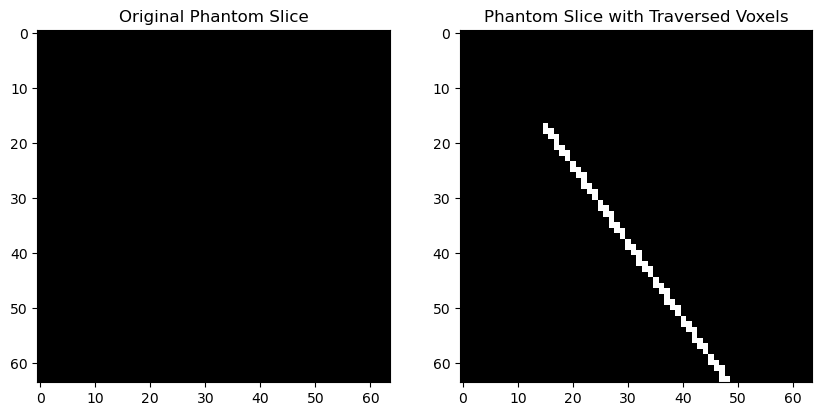

In [72]:
#@title Testing Siddon 3D

# Use the siddon_3d function defined above, with 2 random points, and visualise the traversed pixels in an ndarray plot

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'phantom' and 'siddon_3d' are defined as in the provided code.

# Generate two random 3D points within the phantom's boundaries.
phantom_shape = phantom.shape
p1 = (17, 15, 0)
p2 = (45, 35, 0)

# Call the siddon_3d function.
voxels_traversed, path_lengths = siddon_3d(p1, p2, phan_size)
print(voxels_traversed)
print(path_lengths)

# Create a copy of the phantom to visualize traversed voxels.
phantom_visualization = np.copy(phantom)

# Mark the traversed voxels.
for voxel in voxels_traversed:
  if 0 <= voxel[0] < phantom_shape[-3] and 0 <= voxel[1] < phantom_shape[-2] and 0 <= voxel[2] < phantom_shape[-1]:
    phantom_visualization[chan_scat_coef][voxel] = 1.0  # Or any other distinct value.
    phantom_visualization[chan_atten_coef][voxel] = 1.0  # Or any other distinct value.

# Display a slice of the phantom with the traversed voxels highlighted.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(phantom[chan_scat_coef, :, :, 0], cmap="gray")
plt.title("Original Phantom Slice")
plt.subplot(1, 2, 2)
plt.imshow(phantom_visualization[chan_scat_coef, :, :, 0], cmap="gray")
plt.title("Phantom Slice with Traversed Voxels")
plt.show()


In [ ]:
#@title Siddon Jacobs 3D (In progress)

import math
import sys

def siddon_jacobs_3d(p1: tuple, p2: tuple, phan_size: int, phantom: np.ndarray=None, phantom_rho_chan: int=chan_atten_coef) -> tuple[list, list, float|None]:
  planes = phan_size + 1

  voxels_to_traverse: list[tuple] = []
  voxels_to_traverse_path_lens: list[float] = []

  # The corner of the pixel space where the axes intersect
  b_x = 0
  b_y = 0
  b_z = 0

  # Distance between planes
  d_x = 1
  d_y = 1
  d_z = 1

  def alpha_x(i: int) -> float:
    numerator = (b_x + i * d_x) - p1[0]
    denominator = p2[0] - p1[0] + sys.float_info.epsilon
    return numerator / denominator

  def alpha_y(j: int) -> float:
    numerator = (b_y + j * d_y) - p1[1]
    denominator = p2[1] - p1[1] + sys.float_info.epsilon
    return numerator / denominator

  def alpha_z(k: int) -> float:
    numerator = (b_z + k * d_z) - p1[2]
    denominator = p2[2] - p1[2] + sys.float_info.epsilon
    return numerator / denominator

  alpha_x_min = min(alpha_x(0), alpha_x(planes-1))
  alpha_x_max = max(alpha_x(0), alpha_x(planes-1))
  alpha_y_min = min(alpha_y(0), alpha_y(planes-1))
  alpha_y_max = max(alpha_y(0), alpha_y(planes-1))
  alpha_z_min = min(alpha_z(0), alpha_z(planes-1))
  alpha_z_max = max(alpha_z(0), alpha_z(planes-1))

  alpha_min = max(alpha_x_min, alpha_y_min, alpha_z_min)
  alpha_max = min(alpha_x_max, alpha_y_max, alpha_z_max)

  # print(alpha_min, alpha_max)

  def p_x(alpha: float) -> float:
    return p1[0] + alpha * (p2[0] - p1[0])

  def p_y(alpha: float) -> float:
    return p1[1] + alpha * (p2[1] - p1[1])

  def p_z(alpha: float) -> float:
    return p1[2] + alpha * (p2[2] - p1[2])

  def phi_x(alpha: float) -> float:
    numerator = p_x(alpha) - b_x
    denominator = d_x
    return numerator / denominator

  def phi_y(alpha: float) -> float:
    numerator = p_y(alpha) - b_y
    denominator = d_y
    return numerator / denominator

  def phi_z(alpha: float) -> float:
    numerator = p_z(alpha) - b_z
    denominator = d_z
    return numerator / denominator

  # Determine i_min and i_max, j_min and j_max, k_min and k_max

  i_min: int | None = None
  i_max: int | None = None
  j_min: int | None = None
  j_max: int | None = None
  k_min: int | None = None
  k_max: int | None = None

  if p1[0] < p2[0]:
    i_min = 1 if alpha_min == alpha_x_min else math.ceil(phi_x(alpha_min))
    i_max = planes - 1 if alpha_max == alpha_x_max else math.floor(phi_x(alpha_max))
  else:
    i_max = planes - 2 if alpha_min == alpha_x_min else math.floor(phi_x(alpha_min))
    i_min = 0 if alpha_max == alpha_x_max else math.ceil(phi_x(alpha_max))

  if p1[1] < p2[1]:
    j_min = 1 if alpha_min == alpha_y_min else math.ceil(phi_y(alpha_min))
    j_max = planes - 1 if alpha_max == alpha_y_max else math.floor(phi_y(alpha_max))
  else:
    j_max = planes - 2 if alpha_min == alpha_y_min else math.floor(phi_y(alpha_min))
    j_min = 0 if alpha_max == alpha_y_max else math.ceil(phi_y(alpha_max))

  if p1[2] < p2[2]:
    k_min = 1 if alpha_min == alpha_z_min else math.ceil(phi_z(alpha_min))
    k_max = planes - 1 if alpha_max == alpha_z_max else math.floor(phi_z(alpha_max))
  else:
    k_max = planes - 2 if alpha_min == alpha_z_min else math.floor(phi_z(alpha_min))
    k_min = 0 if alpha_max == alpha_z_max else math.ceil(phi_z(alpha_max))

  # print(i_min, i_max, j_min, j_max, k_min, k_max)

  # Calc arrays alpha_x[] alpha_y[] alpha_z[] which hold parametric vals for intersection points of the
  # ray with the x- respect to y-planes, after the ray has entered pixel space.

  alpha_x_arr: list[float] = []
  alpha_y_arr: list[float] = []
  alpha_z_arr: list[float] = []

  # TODO: does the if/else really do anything?
  if p1[0] < p2[0]:
    alpha_x_arr = [alpha_x(i) for i in range(i_min, i_max+1, 1)]
  else:
    alpha_x_arr = [alpha_x(i) for i in range(i_max, i_min-1, -1)]

  if p1[1] < p2[1]:
    alpha_y_arr = [alpha_y(j) for j in range(j_min, j_max+1, 1)]
  else:
    alpha_y_arr = [alpha_y(j) for j in range(j_max, j_min-1, -1)]

  if p1[2] < p2[2]:
    alpha_z_arr = [alpha_z(k) for k in range(k_min, k_max+1, 1)]
  else:
    alpha_z_arr = [alpha_z(k) for k in range(k_max, k_min-1, -1)]

  # Combine alpha_min, alpha_ x,y,z _arr's together and sort acendingly
  alpha_xyz_arr: list[float] = [alpha_min] + alpha_x_arr + alpha_y_arr + alpha_z_arr + [alpha_max]
  # Remove duplicates
  alpha_xyz_arr = list(set(alpha_xyz_arr))
  alpha_xyz_arr.sort()

  # To calculate coordinates of intersected pixels
  def i(m: int) -> int:
    numerator = alpha_xyz_arr[m] + alpha_xyz_arr[m-1]
    denominator = 2
    return math.floor(phi_x(numerator / denominator))

  def j(m: int) -> int:
    numerator = alpha_xyz_arr[m] + alpha_xyz_arr[m-1]
    denominator = 2
    return math.floor(phi_y(numerator / denominator))

  def k(m: int) -> int:
    numerator = alpha_xyz_arr[m] + alpha_xyz_arr[m-1]
    denominator = 2
    return math.floor(phi_z(numerator / denominator))

  p1p2euclidDist = math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)
  def length(m: int) -> float:
    return (alpha_xyz_arr[m] - alpha_xyz_arr[m-1]) * p1p2euclidDist

  for m in range(1, len(alpha_xyz_arr)):
    voxels_to_traverse.append((i(m), j(m), k(m)))
    voxels_to_traverse_path_lens.append(length(m))

  # print(voxels_to_traverse)
  # print(voxels_to_traverse_path_lens)

  return voxels_to_traverse, voxels_to_traverse_path_lens



In [ ]:
#@title Testing Siddon Jacobs 3D

# Use the siddon_jacobs_3d function defined above, with 2 random points, and visualise the traversed pixels in an ndarray plot

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'phantom' and 'siddon_3d' are defined as in the provided code.

# Generate two random 3D points within the phantom's boundaries.
phantom_shape = phantom.shape
p1 = (-1, -1, 0)
p2 = (16, 16, 1)

# Call the siddon_3d function.
voxels_traversed, path_lengths, d12 = siddon_jacobs_3d(p1, p2, phan_size, phantom)
print(f"d12 line integral final value: {d12}")

# Create a copy of the phantom to visualize traversed voxels.
phantom_visualization = np.copy(phantom)

# Mark the traversed voxels.
for voxel in voxels_traversed:
  if 0 <= voxel[0] < phantom_shape[-3] and 0 <= voxel[1] < phantom_shape[-2] and 0 <= voxel[2] < phantom_shape[-1]:
    phantom_visualization[chan_scat_coef][voxel] = 1.0  # Or any other distinct value.
    phantom_visualization[chan_atten_coef][voxel] = 1.0  # Or any other distinct value.

# Display a slice of the phantom with the traversed voxels highlighted.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(phantom[chan_scat_coef, :, :, 0], cmap="gray")
plt.title("Original Phantom Slice")
plt.subplot(1, 2, 2)
plt.imshow(phantom_visualization[chan_scat_coef, :, :, 0], cmap="gray")
plt.title("Phantom Slice with Traversed Voxels")
plt.show()


In [5]:
#@title Grid and Detector Response (Basic)

def grid_response() -> float:
  return 1

def detec_response() -> float:
  return 1

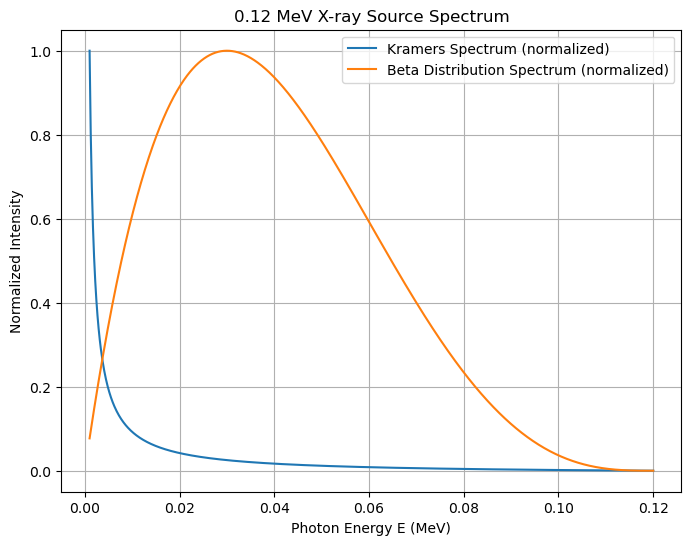

In [6]:
#@title X-Ray Source Spectra

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta as beta_func

# Maximum photon energy (E0) in MeV
E0 = 0.120

# --- Kramers Law Spectrum ---
def kramers_spectrum(E, E0=E0):
    """
    Kramers law: I(E) ∝ (E0 - E)/E for 0 < E < E0.
    For E=0, we define I=0 to avoid division by zero.
    """
    I = np.zeros_like(E)
    valid = (E > 0) & (E < E0)
    I[valid] = (E0 - E[valid]) / E[valid]
    return I

# --- Beta Distribution–Type Spectrum ---
def beta_spectrum(E, E0=E0, alpha=2.0, beta_param=2.0):
    """
    I(E) = I0 * (E/E0)^(alpha-1) * (1 - E/E0)^(beta_param-1)
    for 0 <= E <= E0. The function is normalized (I0 set so that
    the area under the curve equals 1) using the beta function.
    """
    x = E / E0
    I = np.zeros_like(E)
    valid = (E >= 0) & (E <= E0)
    I[valid] = x[valid]**(alpha-1) * (1 - x[valid])**(beta_param-1)
    # Normalize so that the integral over [0, E0] equals 1:
    norm = beta_func(alpha, beta_param) * E0
    return I / norm

# --- Define Energy Grid ---
# We avoid E=0 for Kramers law to prevent division by zero.
E = np.linspace(0.001, E0, 1000)

# Calculate spectra
I_kramers = kramers_spectrum(E, E0)
I_beta = beta_spectrum(E, E0, alpha=2.0, beta_param=4.0)

# Normalize for plotting (maximum value = 1)
I_kramers_norm = I_kramers / np.max(I_kramers)
I_beta_norm = I_beta / np.max(I_beta)

# --- Plotting ---
plt.figure(figsize=(8,6))
plt.plot(E, I_kramers_norm, label="Kramers Spectrum (normalized)")
plt.plot(E, I_beta_norm, label="Beta Distribution Spectrum (normalized)")
plt.xlabel("Photon Energy E (MeV)")
plt.ylabel("Normalized Intensity")
plt.title(f"{E0} MeV X-ray Source Spectrum")
plt.legend()
plt.grid(True)
plt.show()

Total cross section (σ_tot) = 2.561e-29 m²


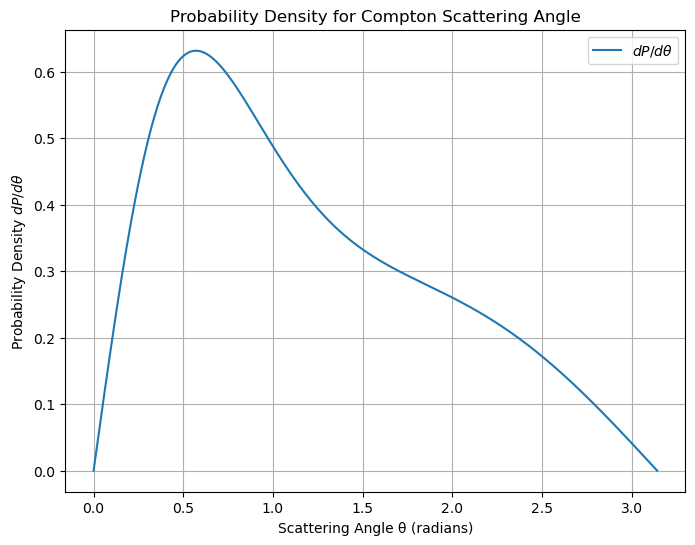

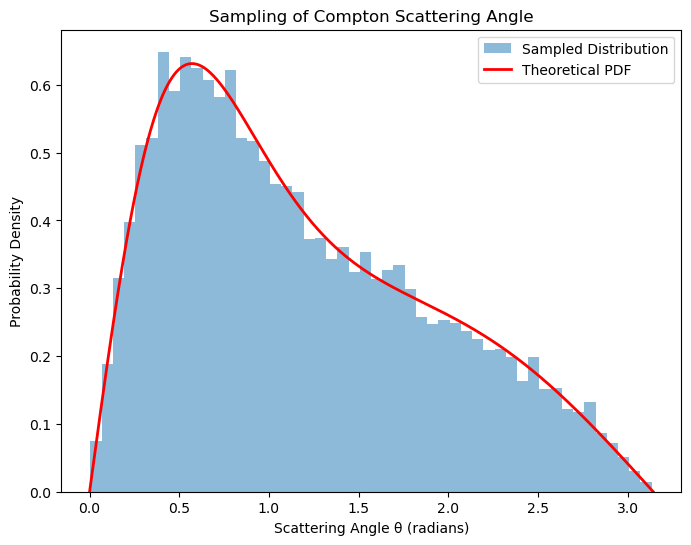

In [7]:
#@title Klein-Nishina Probability

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# ---------------------
# Constants
# ---------------------
r0 = 2.8179403227e-15  # Classical electron radius in meters
m_e_c2 = 0.511         # Electron rest energy in MeV

# ---------------------
# Functions
# ---------------------
def compton_energy(E, theta):
    """
    Compute the scattered photon energy E' given incident energy E (in MeV)
    and scattering angle theta (in radians) using the Compton formula.
    """
    return E / (1 + (E/m_e_c2) * (1 - np.cos(theta)))

def klein_nishina_dsigma_domega(theta, E):
    """
    Compute the Klein-Nishina differential cross section dσ/dΩ as a function of
    scattering angle theta (in radians) and incident energy E (in MeV).
    """
    E_prime = compton_energy(E, theta)
    factor = (E_prime/E)**2
    # Klein-Nishina formula
    return (r0**2 / 2) * factor * ((E/E_prime) + (E_prime/E) - np.sin(theta)**2)

def total_cross_section(E):
    """
    Numerically integrate dσ/dΩ over all solid angles to obtain the total cross section σ_tot.
    Since the expression is independent of the azimuthal angle φ, the integration is:

      σ_tot = 2π ∫₀^π sinθ dθ (dσ/dΩ)(θ, E)
    """
    integral, error = integrate.quad(lambda theta: np.sin(theta) * klein_nishina_dsigma_domega(theta, E), 0, np.pi)
    sigma_tot = 2 * np.pi * integral
    return sigma_tot

def probability_density(theta, E, sigma_tot):
    """
    Compute the probability density dP/dθ for scattering at angle theta.
    """
    return (2 * np.pi * np.sin(theta) * klein_nishina_dsigma_domega(theta, E)) / sigma_tot

# ---------------------
# Example: Compute and Plot PDF for a Given Energy
# ---------------------
test_E = 0.662  # Incident photon energy in MeV (e.g., from Cs-137 gamma ray)
sigma_tot = total_cross_section(test_E)
print(f"Total cross section (σ_tot) = {sigma_tot:.3e} m²")

# Create an array of theta values between 0 and π
thetas = np.linspace(0, np.pi, 500)
pdf = probability_density(thetas, test_E, sigma_tot)

plt.figure(figsize=(8,6))
plt.plot(thetas, pdf, label=r'$dP/d\theta$')
plt.xlabel('Scattering Angle θ (radians)')
plt.ylabel('Probability Density $dP/d\\theta$')
plt.title('Probability Density for Compton Scattering Angle')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------
# Rejection Sampling to Generate Scattering Angles
# ---------------------
def sample_theta(E, sigma_tot, n_samples=10000):
    """
    Sample scattering angles θ from the probability density function using rejection sampling.
    """
    theta_samples = []
    # Estimate the maximum value of the PDF (used for rejection sampling)
    theta_grid = np.linspace(0, np.pi, 500)
    p_vals = probability_density(theta_grid, E, sigma_tot)
    p_max = p_vals.max()

    while len(theta_samples) < n_samples:
        # Sample a candidate uniformly from [0, π]
        theta_candidate = np.random.uniform(0, np.pi)
        # Evaluate the PDF at this candidate
        p_candidate = probability_density(theta_candidate, E, sigma_tot)
        # Sample a uniform random number between 0 and p_max
        u = np.random.uniform(0, p_max)
        if u < p_candidate:
            theta_samples.append(theta_candidate)
    return np.array(theta_samples)

# Generate samples
n_samples = 10000
theta_samples = sample_theta(test_E, sigma_tot, n_samples=n_samples)

# Plot histogram of sampled angles against the theoretical PDF
plt.figure(figsize=(8,6))
plt.hist(theta_samples, bins=50, density=True, alpha=0.5, label='Sampled Distribution')
plt.plot(thetas, pdf, 'r-', lw=2, label='Theoretical PDF')
plt.xlabel('Scattering Angle θ (radians)')
plt.ylabel('Probability Density')
plt.title('Sampling of Compton Scattering Angle')
plt.legend()
plt.show()

In [31]:
#@title Full Generalised Radon Transform for One detector point

import numpy as np

E0 = 0.160 # Redefine here
voxel_physical_scale: float = 0.001 # 1 metre to 1mm thereabouts
theta: float = np.pi * (-1/6)
detec_size: int = phan_size
detec_dims: int = 2
detec_bins: int = 100
detec_max_e_mev: float = E0
detec_min_e_mev: float = 0.001
detec_dist_isocenter: int = detec_size * 0.5 * 3 # "Vaguely" around 50cm from iso
source_dist_isocenter: int = detec_size * 0.5 * 6 # "Vaguely" around 100cm from iso


def generalised_radon_transform(phantom: np.ndarray,
                                theta: float,
                                detec_point: tuple,
                                source_linspace: np.ndarray,
                                bin_linspace: np.ndarray) -> list[float]: # Energy bins for this pixel
  print(f"Beginning generalised radon transform for point {detec_point}")
  # Take line integral for our given theta and detec_point (coordinates on the detector grid, final axis is energy bin)

  e_intensities: dict[float, float] = {} # Key: Energy, Value: Accumulated intensity

  # Small nested function to check if a given coord is within the phantom bounds
  def is_within_bounds(coord: tuple) -> bool:
    return 0 <= coord[0] < phantom.shape[-3] and 0 <= coord[1] < phantom.shape[-2] and 0 <= coord[2] < phantom.shape[-1]

  # We'll rotate around the z axis
  detec_point_physical: np.ndarray = np.array([-detec_dist_isocenter, detec_point[0], detec_point[1]]) # left side
  source_point_physical: np.ndarray = np.array([0, source_dist_isocenter, 0]) # above

  # Translate both in the z axis by theta
  rot_mat: np.ndarray = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
  detec_point_physical = rot_mat @ detec_point_physical.T
  source_point_physical = rot_mat @ source_point_physical.T

  detec_point_physical_opposite = detec_point_physical * -1
  detec_point_physical_opposite[2] = detec_point_physical_opposite[2] * -1 # Keep rotation axis coord same
  source_point_physical_opposite = source_point_physical * -1
  source_point_physical_opposite[2] = source_point_physical_opposite[2] * -1 # Keep rotation axis coord same

  # Make sure to translate these points back to phantom-space, with origin around midpoint of coords, not 0
  detec_point_physical = detec_point_physical + phan_size * 0.5
  detec_point_physical[2] = detec_point_physical[2] - phan_size * 0.5 # Keep rotation axis coord same
  source_point_physical = source_point_physical + phan_size * 0.5
  source_point_physical[2] = source_point_physical[2] - phan_size * 0.5 # Keep rotation axis coord same
  detec_point_physical_opposite = detec_point_physical_opposite + phan_size * 0.5
  detec_point_physical_opposite[2] = detec_point_physical_opposite[2] - phan_size * 0.5 # Keep rotation axis coord same
  source_point_physical_opposite = source_point_physical_opposite + phan_size * 0.5
  source_point_physical_opposite[2] = source_point_physical_opposite[2] - phan_size * 0.5 # Keep rotation axis coord same

  # Let's just turn our points into tuples for ease
  detec_point_physical = (detec_point_physical[0], detec_point_physical[1], detec_point_physical[2])
  source_point_physical = (source_point_physical[0], source_point_physical[1], source_point_physical[2])
  detec_point_physical_opposite = (detec_point_physical_opposite[0], detec_point_physical_opposite[1], detec_point_physical_opposite[2])
  source_point_physical_opposite = (source_point_physical_opposite[0], source_point_physical_opposite[1], source_point_physical_opposite[2])

  # Get traversed pixels from detec_point_physical to detec_point_physical_opposite
  rd_r_voxels_all, rd_r_voxels_all_lens = siddon_3d(detec_point_physical, detec_point_physical_opposite, phan_size)

  # Every voxel in this line is the result of a scatter incident, tracing back to the source.
  # So for each of these voxels (r's), also get the siddon result for r back to our source

  # Let's pre-compute our source beam beta spectrum
  source_spect = beta_spectrum(source_linspace, E0, alpha=2.0, beta_param=4.0)
  source_spect: dict[float, float] = dict(zip(source_linspace, source_spect))

  # We can save (very little) computation time by having a running tally of our rd_r attenuation integral
  # This is under the assumption that our iterations go from detector -> point r
  atten_rd_r_exp_running_integral: float = 0

  for _, (rd_r_voxel, rd_r_voxel_len) in enumerate(dict(zip(rd_r_voxels_all, rd_r_voxels_all_lens)).items()):

    if not is_within_bounds(rd_r_voxel):
      continue

    # Add to the rd_r attenuation tally before we keep looping over E's
    atten_rd_r_exp_running_integral = atten_rd_r_exp_running_integral + phantom[chan_atten_coef][rd_r_voxel] * rd_r_voxel_len * voxel_physical_scale

    # Grab our scattering coefficient now, and if no scattering can occur here,
    # we do not even need to consider propagating back up to r_rs
    r_scat_coef: float = phantom[chan_scat_coef][rd_r_voxel]
    if r_scat_coef == 0:
      continue

    # Get phi between this voxel and source
    r_rd_vec: tuple = (detec_point_physical[0] - rd_r_voxel[0], detec_point_physical[1] - rd_r_voxel[1], detec_point_physical[2] - rd_r_voxel[2])
    r_rs_vec: tuple = (source_point_physical[0] - rd_r_voxel[0], source_point_physical[1] - rd_r_voxel[1], source_point_physical[2] - rd_r_voxel[2])
    phi: float = np.pi - np.arccos(np.dot(r_rd_vec, r_rs_vec) / (np.linalg.norm(r_rd_vec) * np.linalg.norm(r_rs_vec)))

    # Get all the voxels between this voxel and the source
    r_rs_voxels, r_rs_voxels_lens = siddon_3d(rd_r_voxel, source_point_physical, phan_size)

    atten_r_rs_exp_integral: float = 0
    for r_rs_voxel, r_rs_voxel_len in zip(r_rs_voxels, r_rs_voxels_lens):
      if not is_within_bounds(r_rs_voxel):
        continue
      atten_r_rs_exp_integral = atten_r_rs_exp_integral + phantom[chan_atten_coef][r_rs_voxel] * r_rs_voxel_len * voxel_physical_scale

    # We can now compute the inverse square laws for this voxel from source and detector
    inv_sq_rd_r: float = 1 / (np.abs(np.linalg.norm(np.subtract(rd_r_voxel, detec_point_physical))) * voxel_physical_scale) # L2 norm is Euclid dist
    inv_sq_r_rs: float = 1 / (np.abs(np.linalg.norm(np.subtract(rd_r_voxel, source_point_physical))) * voxel_physical_scale) # L2 norm is Euclid dist

    # Let's cache computed Klein-Nishina values for each E', as many will be reused (when phi is fixed)
    klein_nishina_cache_Eprime_fixed_phi: dict[float, float] = {}

    # Let's integrate over all our desired energy bins
    for _, E in np.ndenumerate(bin_linspace):
      e_intensity: float | None = None
      
      # Placeholders
      grid_detec_response = grid_response() * detec_response()

      # Let's integrate over E' which will be from E up to E0, discretised
      # Nested loop: For each voxel from r to rs, see how the intensity lowers due to atten. + inverse sq. law.
      # These are all the energies that RESULT in our E, so sum up these intensities as they come
      eprimes_intensity_integral: float = 0
      for _, Eprime in np.ndenumerate(source_linspace):
        # A quick check here to see if our E' is greater than E
        if Eprime < E:
          continue

        eprime_intensity: float | None = None

        source_I_at_Eprime: float = source_spect[Eprime]
        scaled_I_r_rs: float = source_I_at_Eprime * inv_sq_r_rs

        # At the end of that voxel loop, we can then compute the Klein-Nishina prob that our scat originating from E' happens
        # and scale our tally accordingly
        klein_nishina_prob: float | None = None
        if Eprime in klein_nishina_cache_Eprime_fixed_phi:
          klein_nishina_prob = klein_nishina_cache_Eprime_fixed_phi[Eprime]
        else:
          klein_nishina_prob = klein_nishina_dsigma_domega(phi, Eprime)
          klein_nishina_cache_Eprime_fixed_phi[Eprime] = klein_nishina_prob

        eprime_intensity = scaled_I_r_rs * np.exp(-atten_r_rs_exp_integral) * klein_nishina_prob
        eprimes_intensity_integral = eprimes_intensity_integral + eprime_intensity

      # Now we can compute the final intensity from scatter point r from source all the way to detector, for this energy bin
      e_intensity = grid_detec_response * np.exp(-atten_rd_r_exp_running_integral) * inv_sq_rd_r * eprimes_intensity_integral
      # Don't forget to tag on our scattering coefficient!
      # Teeechnically this should be applied to the whole integral if our logic is for total energy integration
      # But for us, we are discretising bins
      e_intensity = e_intensity * r_scat_coef

      if E in e_intensities:
        e_intensities[E] = e_intensities[E] + e_intensity
      else:
        e_intensities[E] = e_intensity

  detec_point_output: list[float] = []
  for _, bin_E in np.ndenumerate(bin_linspace):
    detec_point_output.append(e_intensities[bin_E] if bin_E in e_intensities else 0)
  print(f"Summed intensity for detec point {detec_point} is {np.sum(detec_point_output)} !")
  return detec_point_output

In [32]:
#@title Iterating Radon transform over detector point grid

from multiprocessing import Pool, cpu_count


def radon_over_detector_pixels(phantom: np.ndarray, detec_size: int, detec_dims: int, detec_bins: int) -> np.ndarray:
  detec_shape: list | tuple = []
  for i in range(0, detec_dims):
    detec_shape.append(detec_size)
  detec_shape.append(detec_bins) # Our bins are not included in the dims size, but we tag it on!
  detec_shape = tuple(detec_shape)
  detec_output: np.ndarray = np.zeros(detec_shape)

  source_linspace: np.ndarray = np.linspace(detec_min_e_mev, E0, detec_bins)
  bin_linspace: np.ndarray = np.linspace(detec_min_e_mev, detec_max_e_mev, detec_bins) # These two linspaces may well be the same

  # Trying out multiprocessing
  cpus: int = cpu_count()
  with Pool(processes=cpus) as pool:
    print(f"Using {cpus} CPUs")

    reses: dict[tuple, np.ndarray] = {}

    for x in range(0, detec_size):
      for y in range(0, detec_size):
        res = pool.apply_async(generalised_radon_transform, args=(phantom,
                                                                  theta,
                                                                  (x, y),
                                                                  source_linspace,
                                                                  bin_linspace
                                                                  ))
        reses[(x,y)] = res

    for x in range(0, detec_size):
      for y in range(0, detec_size):
        detec_output[x,y] = reses[(x,y)].get()

  return detec_output


In [ ]:
#@title Execution of Analytical model

# Use the radon_over_detector_pixels function over our phantom defined above

import matplotlib.pyplot as plt
# Assuming 'phantom', 'phan_size', 'chan_scat_coef', and 'chan_atten_coef' are defined from previous code

print("Beginning the radon transform...")

# Example usage:
radon_output = radon_over_detector_pixels(phantom, detec_size, detec_dims, detec_bins)

# Display the result (you'll likely want to visualize a slice of this 3D array)
# Example for a slice
plt.figure(figsize=(8, 6))
plt.imshow(np.sum(radon_output, axis=2), cmap="gray")  # Assuming you want to visualize the 0th energy bin
plt.title("Radon Transform Output")
plt.colorbar(label="Intensity")
plt.show()
